<a href="https://colab.research.google.com/github/ZvikaZ/SCIgan/blob/master/SCIgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SCIgan - An Automatic CS Paper Generator#

## Data Science Workshop
#### By Elad Yitzhaik and Zvika Haramaty
#### Mentor: Idan Alter
#### 9 June 2020

# Introduction

In this work, we'll try to auto generate papers CS papers, by using GAN.
As a first step, we've created a classifier, that can classify a published paper in CS with ~93% accuracy. Later, we'll extend that with a GAN.

## History

There were several similar attempts, in various directions. The most famous one is probably [SCIgen - An Automatic CS Paper Generator](https://pdos.csail.mit.edu/archive/scigen/) created at circa 2005 by (then) two graduate students at MIT. One of their generated papers was even admitted to a conference...

Although the SCIgen inspired us, it's using a completely different technology - a hand-written context-free grammar.

However, there are even earlier scientific paper generators - such as http://www.elsewhere.org/pomo/, from 1 April 1996, which specialize at generating Post Modernism papers.

That leads us to maybe the most famous fictive scientific paper - [the Sokal hoax](https://en.wikipedia.org/wiki/Sokal_affair). Alan Sokal, a physics professor, sent a meaningless paper, titled "Transgressing the Boundaries: Towards a Transformative Hermeneutics of Quantum Gravity", to a social studies magazine, and it was surprisingly admitted.

Indeed, Sokal didn't use any automatic generators; however, he raised the question of the boundaries between real, meaningful, scientific papers, and bogus papers.

Sadly, analyzing the full implications of Sokal hoax is beyond the scope of this work.

More recent attempt with text generation is [Andrej Karpathy's 'The Unreasonable Effectiveness of Recurrent Neural Networks'](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). He's using a different attitude, of character level generation with RNN, and without GAN; and achieved  quite impressing results, such as fake Wikipedia article, fake scientific paper and even fake Linux kernel source code (including license and comments...)

An interesting review of the 2018 advances in NLP, relevant to our work -  "Finally, a Machine That Can Finish Your Sentence" can be found at [this NY Times article](https://www.nytimes.com/2018/11/18/technology/artificial-intelligence-language.html).

## Methodology

In order to generate a CS paper, we first need to understand what *is* a CS paper. Therefore, in this proposal, we've focused on classifying CS papers.

### Data

We need a large collection of CS papers; some of them published in journals, some of them aren't. A useful option is [arXiv.org](https://arxiv.org/), because it's becoming a common practice to pre-publish papers over there, until the peer review process will finish. Therefore, if we check old enough papers over there, we can distinguish between papers that have been peer reviewed and accepted to publication, and papers that haven't.

Furthermore, the arXiv has the original .tex files, which make it easier to analyze (we don't need to run PDFs through OCR).

### Transfer learning

Following [fast.ai documentation](https://docs.fast.ai/text.html), we're using transfer learning - instead of training our models from scratch, we start from a "good known point" - similar to what is done in vision - where models come pre-trained on [ImageNet](http://www.image-net.org/), and only the last layers are fine tuned. Similar approach for text is using [ULMFiT](https://arxiv.org/abs/1801.06146), a model that has already been trained over the English Wikipedia, and therefore knows a lot about English texts, and only needs fine tuning for the specific field.

### Language model ###

In our approach, we first train a `language model`, that receives a word, and predicts what the next word will be. ~30% accuracy is thought to be good for the general case, and can raise up to 50% for specific fields. We've achieved ~40%.

In this phase, we don't care whether a paper is peer reviewed, or not; we just want our model to 'understand' how text from all kinds of papers look like and 'behave'.

### Classifier ###

With the language model at hand, we can build a classifier. Conveniently, `fast.ai` wraps `NLTK`, and our language model handles the tokenization and conversion to numbers. Now all we need to do is give our language model a labeled dataset, and let it distinguish between peer reviewed and not peer reviewed papers. Thus, we've reached ~93% accuracy.

## Problems with our methodology, and mitigations

1. We haven't found a precedent for efficient large text generation with GAN.
* *but it's still worth trying...*
2. There might be papers in arXiv.org that haven't been peer-reviewed, but are of peer review quality, because of few reasons:
    1. It's still in the peer review process
    * *therefore, we take only papers that have been published at the arXiv at least 3 years ago*
    2. The author believes in Open Source values, and refuses to publish in regular journals
    * *we assume that it's negligible*
    3. The author doesn't want publicity (e.g., the case of [Grigori Perelman's refusal to publish his proof of Poincaré conjecture](https://en.wikipedia.org/wiki/Grigori_Perelman)
    * *we assume that it's even more negligible*
3. Currently our criteria is only whether it was published, in *any* journal
* *we'll address that after the proposal phase, by using only highly ranked journals*
4. There might be papers in arXiv.org that haven't passed peer review, because they were never meant to be sent to peer review
* *it's not really a problem; our classifier needs to differentiate between 'peer-reviewed' and 'not peer-reviewed', and indeed, these papers aren't peer reviewed; thus it should only be a good example*
5. We might have very low ratio of peer reviewed papers out of the total papers
* *currently it's ~10%, and seems OK. If needed, we'll toss some 'not peer-reviewed' papers to improve the ratio*

# Plans for the project ##
1. Add the generation phase.
2. Increase the datasets we're using.
3. Differentiate between the journals which publish papers.
4. Check the influence of the metadata on the results.
5. Currently we've used only AI sub field of CS; we might use other sub fields as well.




In [0]:
# setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline
 
from fastai.text import *
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/SCIgan/'
 
batch_size = 48
OUTPUT_BASE = os.path.join(base_dir, r"clean")
path = Path(OUTPUT_BASE)

np.random.seed(1)

Mounted at /content/gdrive


## Scraping articles from https://arxiv.org ##


In [0]:
#TODO: ELAD - just write here your script
print("Downloading...")

# for now, lat's take if from Google Drive


Downloading...


The papers downloaded from arxiv.org come with directories, each built from 1 or more .tex files (among other, not interesting files)

The code below make a clean copy, with a single .tex file for each paper.
If there's a `main.tex` that imports other files, it's parsed accordingly.
If not, we're searching for the file that behaves as the main file.

In [0]:
import os
import re
import shutil
import sys
IN_COLAB = 'google.colab' in sys.modules

if not IN_COLAB:
    root_dir = 'data_science-20200603T080022Z-001'
    base_dir = '.'

INPUT_BASE = os.path.join(root_dir, 'data_science')     # take from Google drive
OUTPUT_BASE = os.path.join(base_dir, r"clean")

labels = ("peer_reviewed", "not_peer_reviewed")

def warning(msg):
    print("WARNING: " + msg)

def output(label, filename):
    dst = os.path.join(os.path.join(OUTPUT_BASE, label), os.path.basename(os.path.dirname(filename))) + ".tex"

    # I'd rather use simple copy, like this ...
    #shutil.copy(filename, dst)

    # ... but there are files with problematic encodings, we need to clean that
    print("Copying %s to %s" % (filename, dst))
    with open(dst, 'w', encoding='utf8') as output_f:
        with open(filename, encoding='utf8') as input_f:
            try:
                for line in input_f:
                    output_f.write(line)
            except UnicodeDecodeError:
                warning("Decoding error in: " + filename)

def dump_file(output_f, include_file):
    with open(include_file) as f:
        for line in f:
            output_f.write(line)

def parse(label, dir, tex_files, main='main.tex'):
    r = re.compile(r'\\(include|input)\s+(\S+)')

    dst = os.path.join(os.path.join(OUTPUT_BASE, label), os.path.basename(dir)) + ".tex"
    print("Copying %s/%s/*.tex to %s" % (label, dir, dst))

    with open(dst, 'w', encoding='utf8') as output_f:
        with open(os.path.join(dir, main), encoding='utf8') as input_f:
            for line in input_f:
                if r.match(line):
                    included = r.match(line).group(2) + '.tex'
                    # note: currently we assume no recursive includes, we'd check later if it's needed adding
                    dump_file(output_f, os.path.join(dir, included))
                else:
                    output_f.write(line)


def search_main_tex(label, dir, tex_files):
    r = re.compile(r'^\s*\\documentclass')
    for tex_file in tex_files:
        filename = os.path.join(dir, tex_file)
        with open(filename) as f:
            try:
                for line in f:
                    if r.match(line):
                        return tex_file
            except UnicodeDecodeError:
                warning("Decoding error in: " + filename)
    return None


def handle_dir(label, dir):
    tex_files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and f.endswith(".tex")]
    if len(os.listdir(dir)) == 0:
        warning("label %s, empty directory %s" % (label, dir))
    elif len(tex_files) == 0:
        warning("label %s, directory %s without .tex files" % (label, dir))
    elif len(tex_files) == 1:
        output(label, os.path.join(dir, tex_files[0]))
    elif 'main.tex' not in tex_files:
        main = search_main_tex(label, dir, tex_files)
        if main is None:
            warning("label %s, directory %s is without main.tex file" % (label, dir))
        else:
            parse(label, dir, tex_files, main)
    else:
        parse(label, dir, tex_files)


if __name__ == "__main__":
    try:
        shutil.rmtree(OUTPUT_BASE)
    except:
        pass
    os.mkdir(OUTPUT_BASE)

    for label in labels:
        os.mkdir(os.path.join(OUTPUT_BASE, label))
        root = os.path.join(INPUT_BASE, label)
        dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
        for dir in dirs:
            handle_dir(label, os.path.join(root, dir))

Copying /content/gdrive/My Drive/data_science/peer_reviewed/2006.00212v1.tar.gz_extracted/manuscript.tex to /content/gdrive/My Drive/fastai-v3/SCIgan/clean/peer_reviewed/2006.00212v1.tar.gz_extracted.tex
Copying peer_reviewed//content/gdrive/My Drive/data_science/peer_reviewed/2006.00917v1.tar.gz_extracted/*.tex to /content/gdrive/My Drive/fastai-v3/SCIgan/clean/peer_reviewed/2006.00917v1.tar.gz_extracted.tex
Copying /content/gdrive/My Drive/data_science/peer_reviewed/2005.14656v1.tar.gz_extracted/GP.tex to /content/gdrive/My Drive/fastai-v3/SCIgan/clean/peer_reviewed/2005.14656v1.tar.gz_extracted.tex
Copying /content/gdrive/My Drive/data_science/peer_reviewed/2005.13275v1.tar.gz_extracted/celino-human-explanability.tex to /content/gdrive/My Drive/fastai-v3/SCIgan/clean/peer_reviewed/2005.13275v1.tar.gz_extracted.tex
Copying /content/gdrive/My Drive/data_science/peer_reviewed/2005.11797v2.tar.gz_extracted/midl-shortpaper.tex to /content/gdrive/My Drive/fastai-v3/SCIgan/clean/peer_revie

## Language Model

As described in the introduction, after gathering the data, we build a language model - a model that predicts what the next word in the sentence will be.

In [0]:
# take the .tex files
# randomly split and keep 10% for validation
# in this phase, we don't care what's the label of paper (peer reviewed or not)
data_lm = TextList.from_folder(path, extensions={'.tex'}).split_by_rand_pct(0.1).label_for_lm().databunch(bs = batch_size)
          
# through out our code, we'll `save` sometimes, and `load` afterwards
# this allows continuing a new session from the middle, without
# having to start all over again
data_lm.save(base_dir + 'data_lm.pkl')


In [0]:
23wqe4data_lm = load_data(path, base_dir + 'data_lm.pkl', bs=batch_size)
data_lm.show_batch()
 
# transfer learning, starting with Wikipedia model, and fine tuning with our data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

idx,text
0,"\n \n \ xxunk = true , bookmarks = false]{hyperref } \n \n \ cvprfinalcopy % * * * xxmaj uncomment this line for the final submission \n \n \n \ def \ httilde { \ mbox { \ tt \ raisebox{-.5ex } { \ symbol{126 xxrep 4 } \n \n \ setcounter{page}{1 } \n \ begin{document } \n \t \n \t % \t"
1,"they ranged in age from 19 to 70 ( with an average age of 37 ) , and again ranged in self - reported political views from ` ` extremely xxunk ' ' to ` ` extremely conservative ' ' , and in educational achievement from ` ` some high school , no diploma ' ' to ` ` doctorate degree ' ' . xxmaj participants took between 1.5 minutes"
2,"that returns are much higher than those of a single bet . xxmaj this however comes at the expense of an increased risk . xxmaj indeed , only a single selection need to lose for the entire accumulator bet to lose } . \ \ \n \n { xxmaj let us consider for the sake of illustration $ k$ independent single bets ( i.e. no bets on conflicting outcomes"
3,"xxmaj readers that are interested in this technique are suggested to check \ citet{mai2019contextual } for more details . xxunk \ subsection{query xxmaj embedding xxmaj computing } \ label{subsubsec : xxunk } \n \ citet{hamilton2018embedding } proposed a way to compute the query embedding of a xxup cgq $ \ cgq$ based on these three components . xxmaj given a xxup cgq $ \ cgq$ , we can encode"
4,is consensus that a reliable evaluation should --- despite high costs --- be carried out by humans . \n \n xxmaj various methods have been proposed for the human evaluation of xxup mt quality \ xxunk } . xxmaj what they have in common is that the xxup mt output to be rated is paired with a translation hint : the source text or a reference translation . xxmaj


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


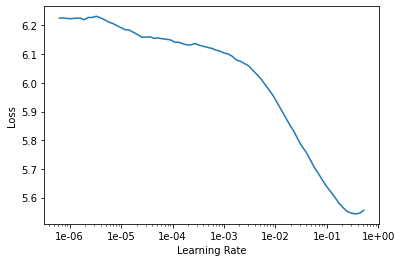

In [0]:
# explore and plot the learning rates
learn.lr_find() 
learn.recorder.plot(skip_end=15)

In [0]:
# train the language model
# we can see from the previous graph that 1e-1 is a good point,
# the loss is still decreasing, and before overfitting
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

# and save our good work
learn.save(base_dir + 'fit_head')
learn.save_encoder(base_dir + 'fit_head_enc')


epoch,train_loss,valid_loss,accuracy,time
0,4.496226,4.028318,0.329913,02:54


In [0]:
# we have reached an accuracy of ~33%, but let's improve it:

# fine tune
learn.load(base_dir + 'fit_head');
learn.unfreeze()
learn.fit_one_cycle(8, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.289804,3.708222,0.361674,03:22
1,3.407731,3.722636,0.356064,03:22
2,3.243773,3.600091,0.375017,03:22
3,3.127868,3.524820,0.385568,03:22
4,2.918436,3.431346,0.395880,03:22
5,2.841487,3.377506,0.405866,03:22
6,2.587384,3.353596,0.412259,03:23
7,2.412118,3.372801,0.411203,03:22


In [0]:
# we have reached 41%, and the loss just starts to raise, let's stop here
# save the model and the encoder
learn.save(base_dir + 'fine_tuned')
learn.save_encoder(base_dir + 'fine_tuned_enc')

In [0]:
# let's check the language model - continue the sentence with 10 random words
learn.load(base_dir + 'fine_tuned');
learn.predict("This is a survey", n_words=10)

'This is a survey , which provides a tool to an INTELLIGENT model'

## Classifier

As described in the introduction, with the learning model we can start build the classifier itself.


In [0]:
path = Path(OUTPUT_BASE)

In [0]:
# build a classifier with:
# - the .tex files
# - same vocabulary used in language model
# - 80% of the data used for learning, 20% of the data used for validation
# - use labels ["peer_reviewed", "not_peer_reviewed"] according to folder names
data_clas = TextList.from_folder(path, extensions={'.tex'}, vocab=data_lm.vocab).split_by_rand_pct(0.2) .label_from_folder(classes=["peer_reviewed", "not_peer_reviewed"]) .databunch(bs = batch_size)
 
data_clas.save(base_dir + 'data_clas.pkl')

In [0]:
data_clas = load_data(path, base_dir + 'data_clas.pkl', bs=batch_size)
data_clas.show_batch()
 
# We can now create a model to classify those reviews and load the encoder we saved before.
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(base_dir + 'fine_tuned_enc')

text,target
"xxbos % version : % xxunk , % dalal27 % xxunk \n % \ def \ year{2018 } \ relax \n % \ documentclass[twoside,11pt]{article } \n \ xxunk , xxunk } \n % \ usepackage{jair , xxunk } \n % \ documentclass[letterpaper]{article } % xxup do xxup not xxup change xxup this \n % \ xxunk } % xxmaj required \n % joe32",not_peer_reviewed
xxbos \ typeout { } \n \ xxunk ghosts of forgotten things : a study on size after forgetting } \n \ typeout { } \n \n \ documentclass[12pt]{article } \n \n % xxunk } \n xxrep 26 % xxmaj miscellaneous \n \n \ let \ xxunk \ relax \n \n \ makeatletter \n \ def \n xxunk { \n,not_peer_reviewed
"xxbos \ documentclass[twoside,11pt]{article } \n \ usepackage{jair , xxunk , xxunk } \n \n \ xxunk / 20 } { ? } \n \ xxunk xxmaj linear xxmaj constraints into xxup sat } \n { xxmaj ab { \ ' \ xxunk , xxmaj mayer - xxmaj eichberger \ & xxmaj xxunk } \n \ xxunk } \n \n \ usepackage{etex } \n",not_peer_reviewed
"xxbos % \n % \n \ xxunk = acmsmall , screen = xxunk } \n % \n \n % \n % \n % \n % \n % \n % \n % \n % \n \n \n ewif \ ifsubmission \n \ xxunk \n \n % \n % \n % \n % \n",not_peer_reviewed
xxbos \ documentclass[11pt]{article } \n \n \ usepackage{fullpage } \n \ usepackage{url } \n \ usepackage{microtype } \n \n \ usepackage[utf8]{inputenc } \n \ usepackage{amsmath } \n \ usepackage{graphicx } \n \ usepackage{upgreek } \n \ usepackage{amsfonts } \n \ usepackage{amssymb } \n \ usepackage{amsthm } \n \ usepackage[mathscr]{euscript } \n \ usepackage{mathtools } \n \ usepackage{multirow,not_peer_reviewed


RNNLearner(data=TextClasDataBunch;

Train: LabelList (316 items)
x: TextList
xxbos \ documentclass[10pt , twocolumn , letterpaper]{article } 
 
  \ usepackage{cvpr } 
  \ usepackage{times } 
  \ usepackage{epsfig } 
  \ usepackage{graphicx } 
  \ usepackage{amsmath } 
  \ usepackage{amssymb } 
  \ usepackage{multirow } 
  \ usepackage{float } 
  % \ usepackage{subfigure } 
  \ usepackage{color } 
  \ usepackage{array } 
  \ usepackage{mathrsfs } 
  \ usepackage{tabularx } 
  \ usepackage{bm } 
  % \ xxunk } 
 
  \ xxunk = true , bookmarks = false]{hyperref } 
 
  \ cvprfinalcopy % * * * xxmaj uncomment this line for the final submission 
 
 
  \ def \ httilde { \ mbox { \ tt \ raisebox{-.5ex } { \ symbol{126 xxrep 4 } 
 
  \ setcounter{page}{1 } 
  \ begin{document } 
 	 
 	 % 	  \ title { xxmaj deep xxmaj sequential xxmaj visual xxmaj understanding through xxmaj semi - xxmaj coupled xxmaj structure } 
 	  \ xxunk xxmaj sequential xxmaj understanding through the xxmaj awareness of xxma

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


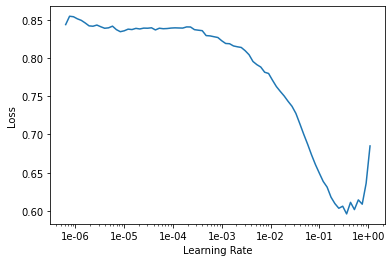

In [0]:
# explore and plot the learning rates
learn.lr_find()
learn.recorder.plot()

In [0]:
# according to the graph, it seems that 2e-2 is a good point -
# the loss is decreasing, before overfitting
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.save(base_dir + 'first')

epoch,train_loss,valid_loss,accuracy,time
0,0.866141,0.672836,0.645570,01:56


In [0]:
# now we start 'peeling' layer after layer, and fine tune
learn.load(base_dir + 'first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save(base_dir + 'second')

epoch,train_loss,valid_loss,accuracy,time
0,0.605608,0.523277,0.924051,01:54


In [0]:
learn.load(base_dir + 'second');
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save(base_dir + 'third')

epoch,train_loss,valid_loss,accuracy,time
0,0.489047,0.441886,0.936709,01:54


In [0]:
learn.load(base_dir + 'third');
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3) , moms=(0.8,0.7))
learn.save(base_dir + 'final')

epoch,train_loss,valid_loss,accuracy,time
0,0.454464,0.440046,0.936709,02:02
1,0.454871,0.432176,0.936709,01:58
